# Batch run analysis

Qsub each tile after breaking input datasets into 8 tiles.  Also, interactive testing below

In [1]:
%matplotlib inline

import os
import sys
import warnings
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

## Open data

In [2]:
# NDVI data
# ds_path = f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'
# ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
# ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
# ds = ds['NDVI']
# del ds.attrs['grid_mapping']

# GPP datasets: DIFFUSE, MODIS, AusEFlux
# ds_path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/DIFFUSE_GPP_5km_2003_2021.nc'
# ds_path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/MODIS_GPP_5km_2002_2021.nc'
ds_path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/AusEFlux_GPP_5km_2003_2023.nc'
ds = assign_crs(xr.open_dataset(ds_path)['GPP'], crs='EPSG:4326')
del ds.attrs['grid_mapping']

#covars
covariables =  xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/covars.nc')
covariables = covariables.drop_vars('wcf')

#soil signal if using NDVI
ss_path = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/ndvi_of_baresoil_5km.nc'
ss = assign_crs(xr.open_dataset(ss_path)['NDVI'], crs='epsg:4326')
ss.name = 'NDVI'

#---------testing slices-----------------------------------------
# ds = ds.isel(latitude=slice(200,352), longitude=slice(50,302)) 
# covariables = covariables.isel(latitude=slice(200,352), longitude=slice(50,302))
# ss = ss.isel(latitude=slice(200,352), longitude=slice(50,302))

# ds = ds.isel(latitude=slice(200,252), longitude=slice(50,202)) 
# covariables = covariables.isel(latitude=slice(200,252), longitude=slice(50,202))
# ss = ss.isel(latitude=slice(200,252), longitude=slice(50,202))

## Split data into tiles

<!-- Running all of Aus just takes too long, >500,000 pixels * > 14,000 time steps - dask graph is huge! -->

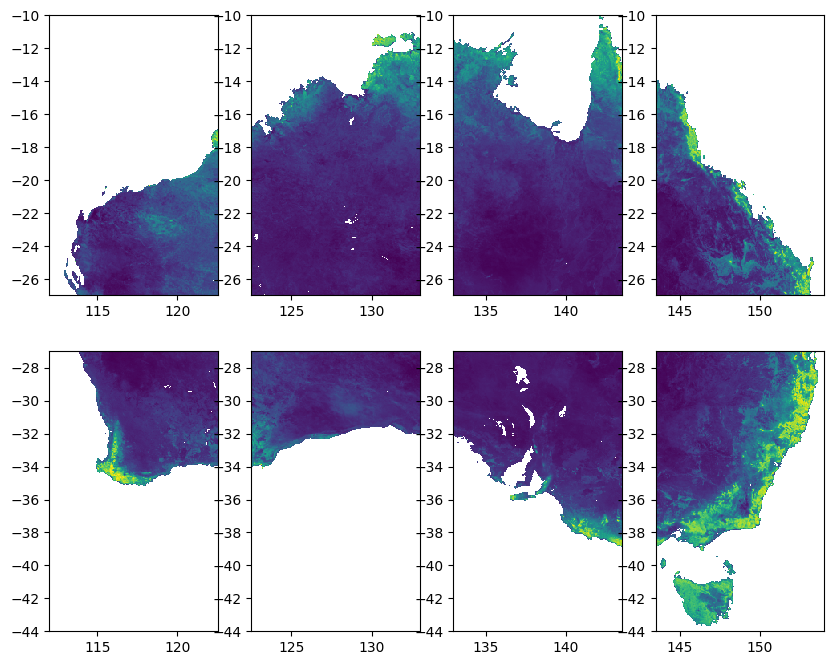

In [3]:
# Function to split into spatial tiles
def split_spatial_tiles(data_array, lat_dim='latitude', lon_dim='longitude', n_lat=2, n_lon=4):
    lat_size = data_array.sizes[lat_dim] // n_lat
    lon_size = data_array.sizes[lon_dim] // n_lon
    
    tiles = []
    for i in range(n_lat):
        for j in range(n_lon):
            tile = data_array.isel({
                lat_dim: slice(i * lat_size, (i + 1) * lat_size),
                lon_dim: slice(j * lon_size, (j + 1) * lon_size)
            })
            tiles.append(tile)
    
    return tiles

# Split data into spatial tiles (2 latitude x 4 longitude)
tiles = split_spatial_tiles(ds, n_lat=2, n_lon=4)
covars_tiles = split_spatial_tiles(covariables, n_lat=2, n_lon=4)
ss_tiles = split_spatial_tiles(ss, n_lat=2, n_lon=4)

#verify no overlaps or missing pixels.
assert np.sum(xr.combine_by_coords(tiles).longitude == ds.longitude) == len(ds.longitude)
assert np.sum(xr.combine_by_coords(tiles).latitude == ds.latitude) == len(ds.latitude)

# create named dictonary
tile_names=['NW', 'NNW', 'NNE', 'NE',
            'SW', 'SSW', 'SSE', 'SE']
tiles_dict = dict(zip(tile_names, tiles))
covars_tiles_dict = dict(zip(tile_names, covars_tiles))
ss_tiles_dict = dict(zip(tile_names, ss_tiles))

#create a plot to visualise tiles
fig,axes = plt.subplots(2, 4, figsize=(10,8))
for t,ax in zip(tiles, axes.ravel()):
    t.isel(time=range(0,20)).mean('time').plot(ax=ax, add_colorbar=False, add_labels=False)
    ax.set_title(None);

## Export

In [4]:
for k,v in tiles_dict.items():
    v.to_netcdf(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/tiles/{ds.name}_{k}.nc')

NW


/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


NNW
NNE
NE
SW
SSW
SSE
SE


In [5]:
for k,v in covars_tiles_dict.items():
    v.to_netcdf(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/tiles/COVARS_{k}.nc')

NW
NNW
NNE
NE
SW
SSW
SSE
SE


In [6]:
for k,v in ss_tiles_dict.items():
    del v.attrs['grid_mapping']
    v.to_netcdf(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/tiles/SS_{k}.nc')

NW
NNW
NNE
NE
SW
SSW
SSE
SE


## Submit tiles to PBS job queue

In [7]:
import os

In [8]:
tiles = ["'NW'", "'NNW'", "'NNE'", "'NE'", "'SW'", "'SSW'", "'SSE'", "'SE'"]  
# tiles = ["'SW'", "'SSW'", "'SSE'", "'SE'"] 
os.chdir('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/')
for t in tiles:
    print(t)
    os.system("qsub -v TILENAME="+t+" src/run_single_tile.sh")

'NW'
135176742.gadi-pbs
'NNW'
135176743.gadi-pbs
'NNE'
135176744.gadi-pbs
'NE'
135176745.gadi-pbs
'SW'
135176746.gadi-pbs
'SSW'
135176747.gadi-pbs
'SSE'
135176748.gadi-pbs
'SE'
135176749.gadi-pbs


In [9]:
!qstat

Job id                 Name             User              Time Use S Queue
---------------------  ---------------- ----------------  -------- - -----
135126739.gadi-pbs     sys-dashboard-s* cb3058            04:36:10 R normalsr-exec   
135176742.gadi-pbs     run_single_tile* cb3058            00:00:00 R normalsr-exec   
135176743.gadi-pbs     run_single_tile* cb3058            00:00:00 R normalsr-exec   
135176744.gadi-pbs     run_single_tile* cb3058            00:00:03 R normalsr-exec   
135176745.gadi-pbs     run_single_tile* cb3058            00:00:00 R normalsr-exec   
135176746.gadi-pbs     run_single_tile* cb3058            00:00:00 R normalsr-exec   
135176747.gadi-pbs     run_single_tile* cb3058            00:00:00 R normalsr-exec   
135176748.gadi-pbs     run_single_tile* cb3058            00:00:00 R normalsr-exec   
135176749.gadi-pbs     run_single_tile* cb3058            00:00:00 R normalsr-exec   


In [ ]:
# !qdel 135172378.gadi-pbs

## Run interactively instead

Good for testing etc.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import start_local_dask

sys.path.append('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/src/')
from batch_run_analysis import attribution_etal

### Variables for script

In [ ]:
model_var='GPP'#'NDVI'
n_workers=13
memory_limit='60GiB'
modelling_vars=['co2', 'srad', 'rain', 'tavg', 'vpd']
results_path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/tiles/DIFFUSE_GPP/'
template_path='/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/templates/'
model_types = ['PLS'] #'PLS', 'delta_slope', 'ML'

In [ ]:
start_local_dask(
        n_workers=n_workers,
        threads_per_worker=1,
        memory_limit=memory_limit
                    )

In [ ]:
tiles = ['NW','NNW', 'NNE', 'NE', 'SW', 'SSW', 'SSE', 'SE'] # 

for t in tiles:
    print(t)
    attribution_etal(
        n=t,
        results_path=results_path,
        template_path=template_path,
        modelling_vars=modelling_vars,
        model_var=model_var,
        model_types=model_types
    )
    break

In [ ]:
import xarray as xr
import numpy as np
trends = xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/tiles/DIFFUSE_GPP/GPP_trends_perpixel_NW.nc')
# trends.p_value.plot(robust=True, cmap='BrBG');

In [ ]:
attr = xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/tiles/attribution_PLS_perpixel_NW.nc')
# attr['delta_slope'].sel(feature='rain').plot(robust=True)

In [ ]:
beta = xr.open_dataset(f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/tiles/DIFFUSE_GPP/beta_coefficient_perpixel_NW.nc')

In [ ]:
beta['beta'].plot(robust=True)